# Evolutionary Computation - Assignment 10: Own Method
Bartosz Stachowiak 148259<br>
Andrzej Kajdasz 148273

## 1. Problem Statement

There are columns of integers representing nodes. Each row corresponds to a node and contains its x and y coordinates in a plane, as well as a cost associated with the node. There were 4 such data sets each consisting of 200 rows (each representing a single node).

Problem to solve is to choose precisely 50% of the nodes (rounding up if there is an odd number of nodes) and create a Hamiltonian cycle (a closed path) using this subset of nodes. The goal is to minimize the combined total length of the path and the total cost of the selected nodes.

To calculate the distances between nodes, the Euclidean distance formula was used and then round the results to the nearest integer. As suggested, the distances between the nodes were calculated after loading the data and placed in a matrix, so that during the subsequent evaluation of the problem, it was only necessary to read these values which reduced the cost of the operation of the algorithm.

### 1.1 Algorithm description

## 2. Pseudocode of all implemented algorithms

## 3. Results of the computational experiments

In [30]:
import pathlib
import itertools

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from common import *

In [31]:
DATA_FOLDER = './data/'
OLD_RESULTS_FOLDER = f'{DATA_FOLDER}old_results/'
RESULT_FOLDER = f'{DATA_FOLDER}results/'
INSTANCE_FOLDER = f'{DATA_FOLDER}tsp_instances/'

SOLVERS = {
    "lsap-5-r": "Adjusted Genetic LS (Pop 5)",
    "lsap-10-r": "Adjusted Genetic LS (Pop 10)",
    "lsap-20-r": "Adjusted Genetic LS (Pop 20)",
    "lsap-30-r": "Adjusted Genetic LS (Pop 30)",
    "lsap-50-r": "Adjusted Genetic LS (Pop 50)",
}

OLD_SOLVERS = {
    "lseo-75-r": "Genetic LS, without post-recombine LS (Pop 75)",
    "lsep-5-r": "Genetic LS, with steepest post-recombine LS (Pop 5)",
    "lsep-20-r": "Genetic LS, with steepest post-recombine LS (Pop 20)",
    "lsnp-10-r" : "LNS Steepest LS (D10)",
    "lsnp-20-r" : "LNS Steepest LS (D20)",
    "lsnp-30-r" : "LNS Steepest LS (D30)",
    "lsnp-50-r" : "LNS Steepest LS (D50)",
    "lsnp-75-r" : "LNS Steepest LS (D75)",
    "lsno-75-r" : "LNS no LS (D75)",
}

OLD_SOLVERS_NO_ITER = {
    "lsm-r" : "Steepest Multi Start LS",
    "lsi-10-r" : "Iterated LS (Perturbation size 10)",
    "lsi-20-r" : "Iterated LS (Perturbation size 20)",
}
SOLVERS_TO_PLOT = SOLVERS.copy()
OLD_SOLVERS = {**OLD_SOLVERS_NO_ITER, **OLD_SOLVERS}
SOLVERS = {**OLD_SOLVERS, **SOLVERS}
NUM_NODES = 200

instance_files = [path for path in pathlib.Path(INSTANCE_FOLDER).iterdir() if path.is_file()]
instance_names = [path.name[:4] for path in instance_files]
p_sizes = [5, 10, 20, 30, 50]

In [32]:
instances_data = {
    name: read_instance(f'{INSTANCE_FOLDER}{name}.csv')
    for name in instance_names
}

In [33]:
instances_solvers_pairs = itertools.product(instances_data.keys(), SOLVERS.keys())

all_results = {}
all_costs = {}
all_times = {}
all_stats = {}
all_no_iterations = {}

for instance, solver in instances_solvers_pairs:
    all_results[instance] = all_results.get(instance, {})
    all_costs[instance] = all_costs.get(instance, {})
    all_times[instance] = all_times.get(instance, {})
    all_stats[instance] = all_stats.get(instance, {})
    all_no_iterations[instance] = all_no_iterations.get(instance, {})
    costs = []
    times = []
    paring_results = []
    iterations = []
    for idx in range(20):
        folder = OLD_RESULTS_FOLDER if solver in OLD_SOLVERS else RESULT_FOLDER
        if solver in OLD_SOLVERS_NO_ITER:
            solution, cost, time = read_solution(f'{folder}{instance}-{solver}-{idx}.txt')
        else:
            solution, cost, time, no_iterations = read_solution_three_feature(f'{folder}{instance}-{solver}-{idx}.txt')
            iterations.append(no_iterations)
        paring_results.append(solution)
        costs.append(cost)
        times.append(time)
        
    all_results[instance][solver] = np.array(paring_results)
    all_costs[instance][solver] = np.array(costs)
    all_stats[instance][solver] = {
        'mean': np.mean(costs),
        'std': np.std(costs),
        'min': np.min(costs),
        'max': np.max(costs),
    }
    all_times[instance][solver] = {
        'mean': np.mean(times),
        'std': np.std(times),
        'min': np.min(times),
        'max': np.max(times),
    }
    if solver not in OLD_SOLVERS_NO_ITER:
        all_no_iterations[instance][solver] = {
            'mean': np.mean(iterations),
            'std': np.std(iterations),
            'min': np.min(iterations),
            'max': np.max(iterations),
        }

In [34]:
costs_df = pd.DataFrame(all_stats).T
max_df = pd.DataFrame(all_stats).T
min_df = pd.DataFrame(all_stats).T
iterations_df = pd.DataFrame(all_no_iterations).T

for column in SOLVERS.keys():
    costs_df[column] = costs_df[column].apply(lambda x: f'{x["mean"]:.0f} ({x["min"]:.0f} - {x["max"]:.0f})')
    max_df[column] = max_df[column].apply(lambda x: x['max'])
    min_df[column] = min_df[column].apply(lambda x: x['min'])
    if column not in OLD_SOLVERS_NO_ITER:
        iterations_df[column] = iterations_df[column].apply(lambda x: f'{x["mean"]:.0f} ({x["min"]:.0f} - {x["max"]:.0f})')

for df in [costs_df, max_df, min_df, iterations_df]:
    df.rename(columns=SOLVERS, inplace=True)

### 3.1. Visualizations and statistics of cost for all dataset-algorithm pairs

In tabular form we present the Mean, Minimum and Maximum of the results of the algorithms for each dataset.

In [35]:
print("Mean (min-max) of the costs:")

best_means = {
    instance: min(all_stats[instance][solver]['mean'] for solver in SOLVERS.keys())
    for instance in instance_names
}

def apply_style(v: str, best_val: float):
    num = v.split()[0]
    try:
        num = float(num)
    except ValueError:
        return ""
    if round(num) == round(best_val):
        return "font-weight: bold; color: red"
    return ""
    


costs_df.T.style.apply(lambda x: [
    apply_style(v, best_means[x.index[i]])
    for i, v in enumerate(x)
], axis = 1)

Mean (min-max) of the costs:


,TSPA,TSPB,TSPC,TSPD
Steepest Multi Start LS,75183 (74052 - 75561),68280 (67668 - 68821),49204 (48692 - 49702),45574 (44647 - 46030)
Iterated LS (Perturbation size 10),75149 (74236 - 75967),68240 (67079 - 68948),49119 (48668 - 49624),45721 (45093 - 46356)
Iterated LS (Perturbation size 20),74522 (73144 - 75914),67883 (67069 - 68480),49074 (48524 - 49912),45433 (44434 - 46070)
"Genetic LS, without post-recombine LS (Pop 75)",75501 (74813 - 75871),68416 (67964 - 68793),49527 (48970 - 49916),46009 (45405 - 46566)
"Genetic LS, with steepest post-recombine LS (Pop 5)",73444 (73126 - 73810),66503 (66232 - 66867),48005 (47491 - 48685),44758 (43708 - 45510)
"Genetic LS, with steepest post-recombine LS (Pop 20)",73923 (73042 - 76138),66932 (66264 - 68714),48944 (47489 - 50643),45909 (44541 - 47388)
LNS Steepest LS (D10),73714 (72855 - 74473),67036 (66561 - 68437),47750 (47314 - 48255),44031 (43222 - 45007)
LNS Steepest LS (D20),73326 (72855 - 74074),66808 (66396 - 67741),47817 (47159 - 48480),43954 (43232 - 44747)
LNS Steepest LS (D30),73339 (72855 - 73937),66753 (66117 - 67401),47640 (46910 - 48770),44012 (43235 - 44937)
LNS Steepest LS (D50),73185 (72855 - 73449),66628 (66232 - 67109),47590 (47143 - 48450),44086 (43168 - 45523)


### 3.2 Mean number of iterations

Time limits:
- TSPA: 9.12 s
- TSPB: 8.62 s
- TSPC: 6.5 s
- TSPD: 5.4 s

In [36]:
print("Mean (min-max) of the iterations:")
iterations_df.T

Mean (min-max) of the iterations:


,TSPA,TSPB,TSPC,TSPD
"Genetic LS, without post-recombine LS (Pop 75)",105 (1 - 605),52 (1 - 477),1 (1 - 1),1 (1 - 1)
"Genetic LS, with steepest post-recombine LS (Pop 5)",425 (80 - 1060),371 (111 - 899),282 (50 - 646),181 (41 - 414)
"Genetic LS, with steepest post-recombine LS (Pop 20)",274 (1 - 855),204 (1 - 670),149 (1 - 491),72 (1 - 310)
LNS Steepest LS (D10),2498 (1168 - 4759),2509 (997 - 4713),2191 (1087 - 3366),1795 (678 - 2724)
LNS Steepest LS (D20),1710 (823 - 3080),1785 (626 - 3070),1489 (570 - 2200),1153 (553 - 1753)
LNS Steepest LS (D30),1515 (567 - 2503),1305 (497 - 2332),1131 (425 - 1484),1026 (441 - 1608)
LNS Steepest LS (D50),929 (470 - 1601),726 (355 - 1666),722 (334 - 1232),658 (281 - 1044)
LNS Steepest LS (D75),584 (349 - 1184),663 (266 - 1141),599 (232 - 894),570 (204 - 1183)
LNS no LS (D75),819 (360 - 1464),795 (312 - 1419),599 (263 - 1045),597 (248 - 1133)
Genetic LS (Pop 5),6219 (2430 - 10466),6311 (2483 - 10342),4609 (2008 - 8765),3184 (939 - 4989)


 ### 3.3. Visualizations of the impact of population size on the iterations number and mean cost

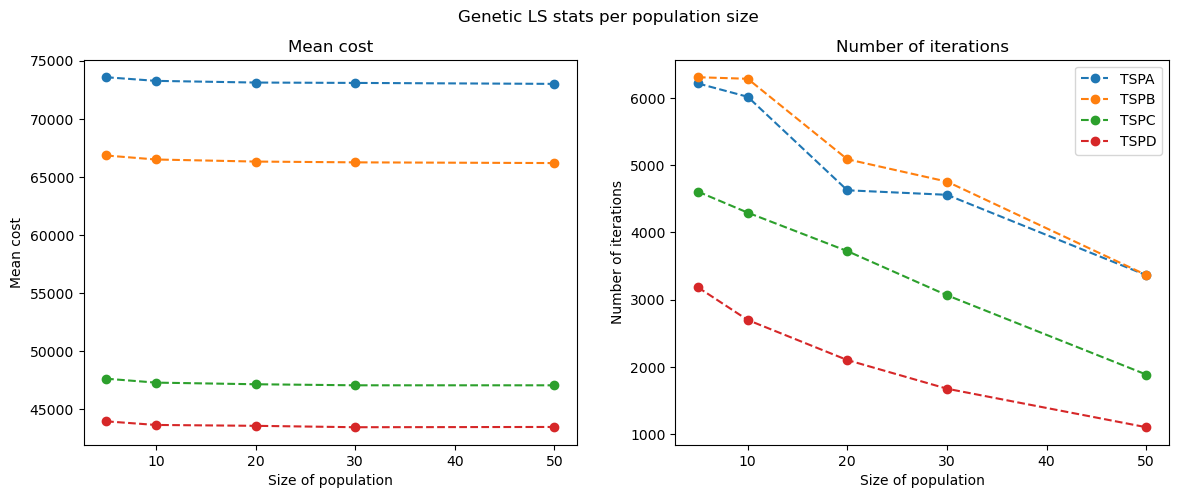

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for instance in instances_data.keys():
    
    axs[0].plot(
        p_sizes,
        [all_stats[instance][f"lsap-{n}-r"]['mean'] for n in p_sizes],
        label=instance,
        marker='o', 
        linestyle='dashed'
    )
    axs[1].plot(
        p_sizes,
        [all_no_iterations[instance][f"lsap-{n}-r"]['mean'] for n in p_sizes],
        label=instance,
        marker='o', 
        linestyle='dashed'
    )

plt.suptitle(f'Genetic LS stats per population size')

axs[0].set_title("Mean cost")
axs[0].set_xlabel('Size of population')
axs[0].set_ylabel('Mean cost')

axs[1].set_title('Number of iterations')
axs[1].set_xlabel('Size of population')
axs[1].set_ylabel('Number of iterations')

plt.legend()
plt.show()

## 4. Best solutions for all datasets and algorithms

To more easily compare the results, we present the best solutions for each dataset side by side.

The weight of each node is denoted both by its size and color. The bigger and brighter the node, the higher its weight.

### 4.1 New algortithms

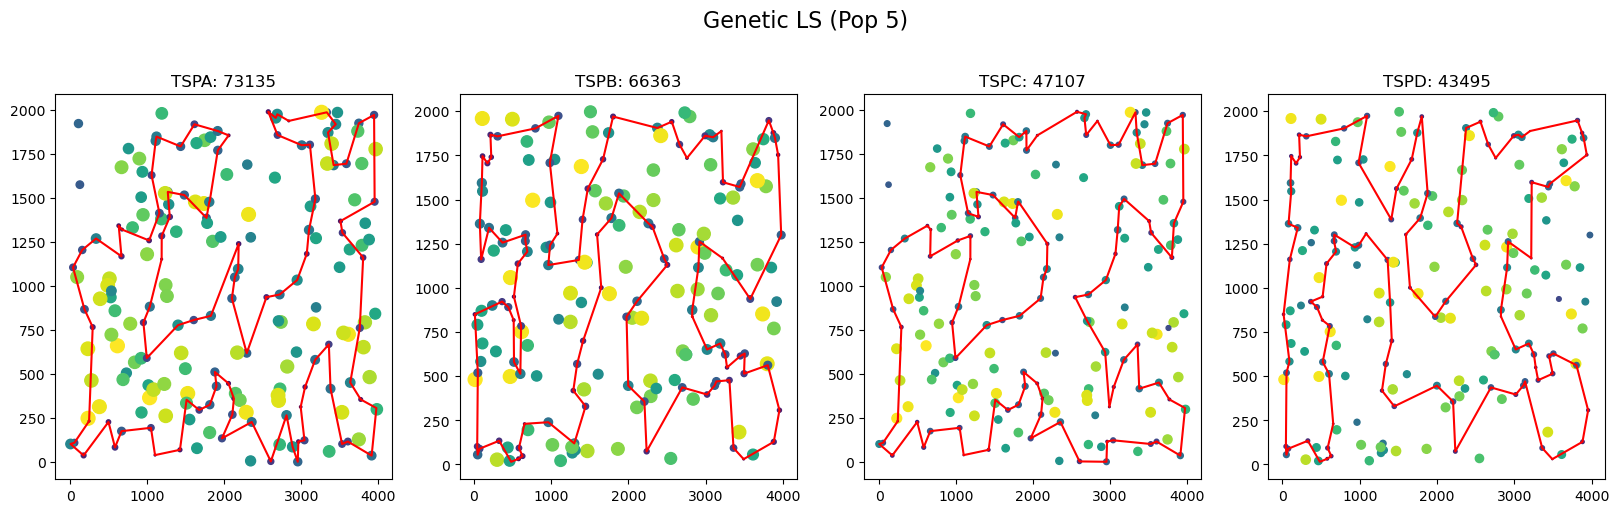

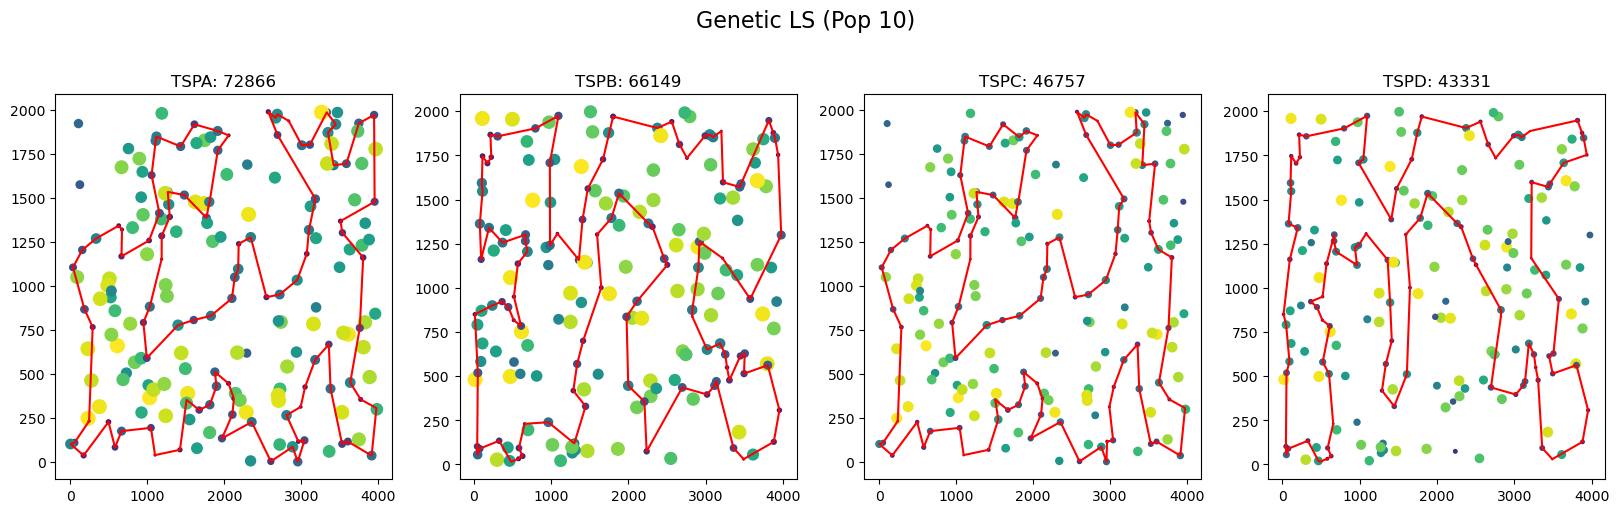

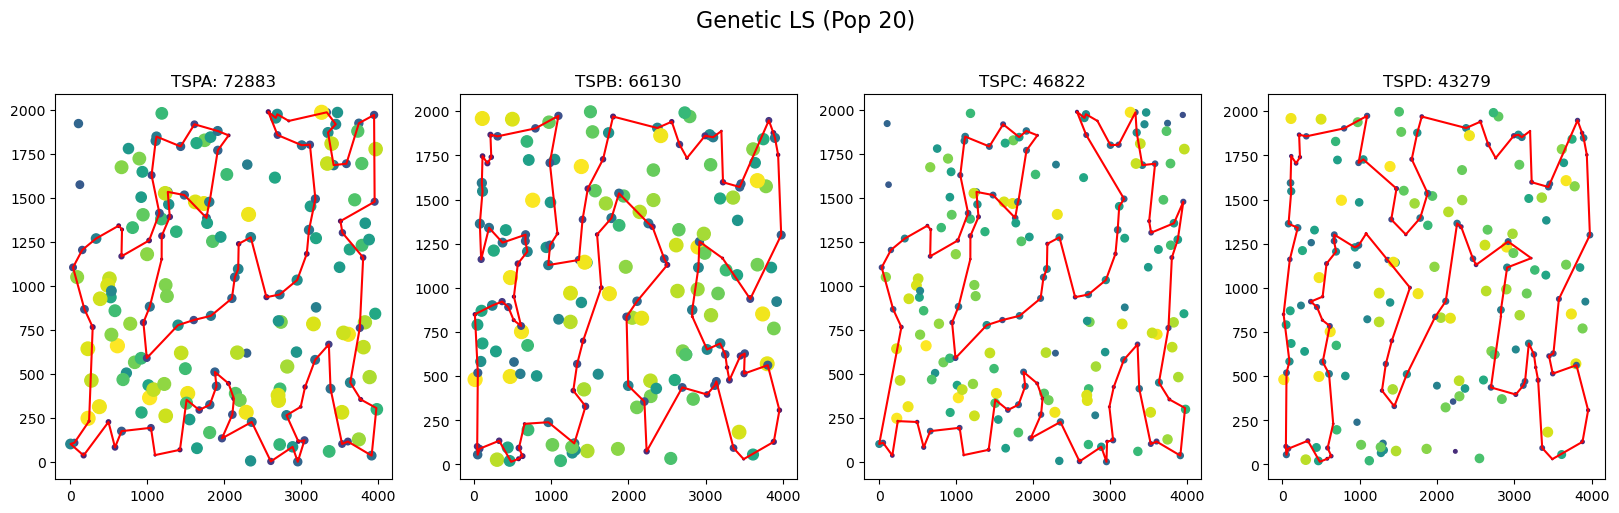

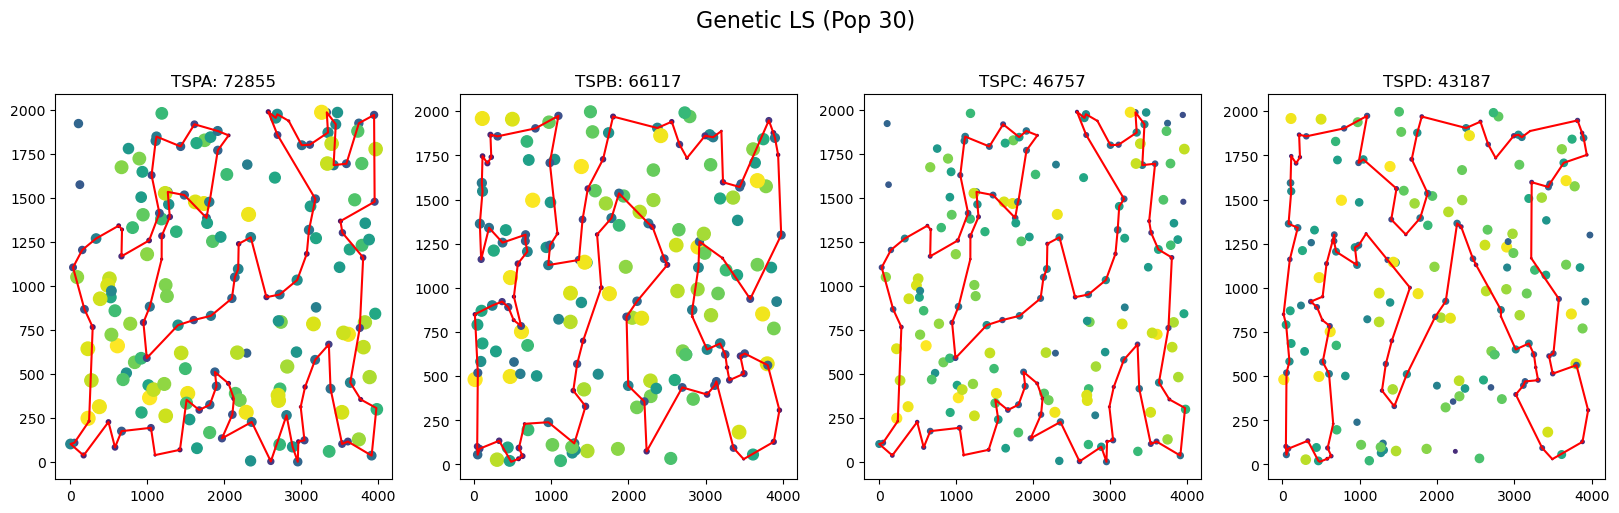

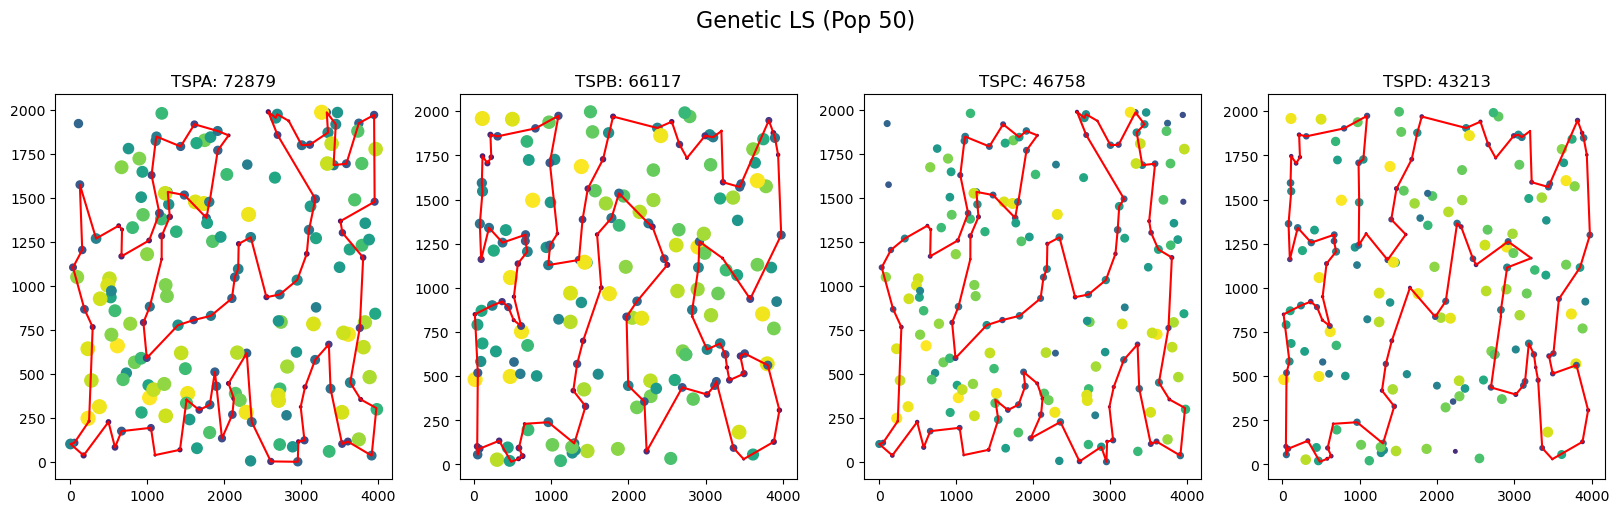

In [38]:
for solver_idx, solver in enumerate(SOLVERS_TO_PLOT.keys()):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    for idx, instance in enumerate(instances_data.keys()):
        best_instance_idx = np.argmin(all_costs[instance][solver])
        plot_solution_for_instance(instances_data[instance], all_results[instance][solver][best_instance_idx], axs[idx])
        axs[idx].set_title(f'{instance}: {all_costs[instance][solver][best_instance_idx]:.0f}')
    fig.suptitle(f'{SOLVERS[solver]}', fontsize=16, y=1.05)
plt.show()

### 4.2 Best solution for each instance from all algorithms

TSPA
	Solver: LNS Steepest LS (D10), Total cost: 72855
	 Nodes: [0, 149, 50, 121, 91, 114, 4, 77, 43, 192, 199, 174, 137, 41, 177, 1, 75, 189, 109, 119, 130, 152, 11, 160, 106, 48, 92, 26, 8, 169, 95, 80, 14, 111, 31, 73, 89, 94, 12, 72, 190, 98, 156, 172, 6, 66, 112, 51, 135, 99, 101, 167, 45, 186, 127, 88, 153, 161, 76, 145, 128, 132, 36, 55, 22, 117, 15, 108, 171, 21, 194, 79, 87, 141, 144, 154, 81, 180, 32, 62, 53, 195, 113, 74, 163, 61, 71, 20, 64, 185, 96, 27, 116, 147, 59, 143, 159, 164, 178, 19]

TSPB
	Solver: LNS Steepest LS (D30), Total cost: 66117
	 Nodes: [0, 169, 66, 26, 92, 122, 143, 179, 121, 127, 24, 131, 103, 38, 101, 31, 197, 183, 34, 5, 2, 182, 163, 172, 95, 135, 198, 190, 19, 33, 29, 18, 16, 8, 63, 82, 115, 69, 53, 142, 130, 141, 148, 140, 174, 51, 70, 91, 156, 67, 158, 162, 150, 117, 196, 44, 71, 193, 119, 59, 166, 85, 114, 72, 171, 58, 89, 129, 64, 159, 147, 181, 170, 189, 12, 107, 139, 52, 132, 185, 73, 136, 79, 145, 157, 80, 153, 55, 88, 137, 37, 165, 36, 25, 13

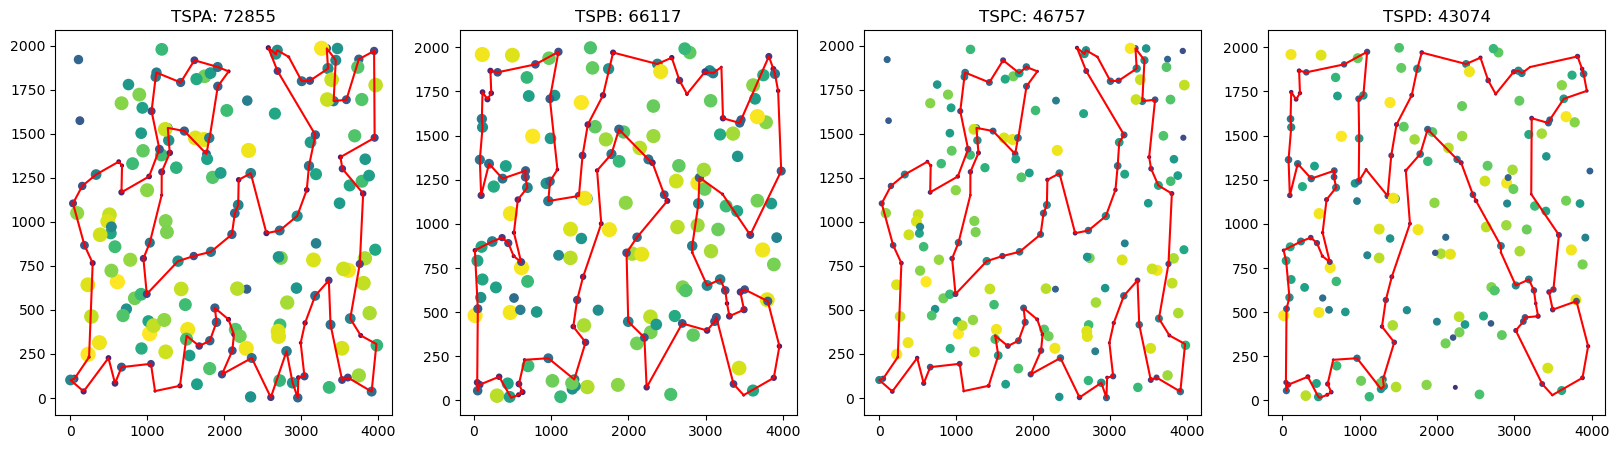

In [39]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for idx, instance in enumerate(instances_data.keys()):
    best_cost =  np.inf
    for solver_idx, solver in enumerate(SOLVERS.keys()):
         if best_cost > np.min(all_costs[instance][solver]):
                best_cost = np.min(all_costs[instance][solver])
                best_result = all_results[instance][solver][np.argmin(all_costs[instance][solver])], 
                best_solver = solver
    best_instance_idx = np.argmin(all_costs[instance][best_solver])
    plot_solution_for_instance(instances_data[instance], all_results[instance][best_solver][best_instance_idx], axs[idx])
    axs[idx].set_title(f'{instance}: {all_costs[instance][best_solver][best_instance_idx]:.0f}')
    print(instance)
    print(f'\tSolver: {SOLVERS[best_solver]}, Total cost: {best_cost}')
    nodes = list(best_result[0])
    if 0 in best_result[0]:
        zero_index = np.where(best_result[0] == 0)[0][0]
        nodes = list(best_result[0][zero_index:])+list(best_result[0][:zero_index])
    print(f'\t Nodes: {nodes}\n')
plt.show()

## 5. Source Code

[GitHub](https://github.com/Tremirre/ECP)

## 6. Conclusions

Analyzing the results and visualizations, one can come to several conclusions about the algorithms used in the task:
- The algorithm created achieved better average results than all those implemented so far. 
- For the TSPA and TSPB instances, the best results obtained are identical to those obtained by Large Neighbourhood Search. So there is a chance that this local minimum is also the global optimum or very close to it. For TSPC, the minimum obtained is the best among the other algorithms. For the TSPD instance, the minimum score is 100 worse than that obtained by LNS. 
- From the experiments, it can be seen that the larger the population, the better the average result obtained, despite a significant decrease in the number of iterations.